In [37]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import seaborn as sns
import matplotlib.pyplot as plt

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):

        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]


        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        
# RMSprop optimizer
class Optimizer_RMSprop:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations)) 
            
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
        
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1
              

In [38]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)

In [39]:
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

In [40]:
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

In [41]:
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

In [42]:
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [43]:
optimizer = Optimizer_RMSprop(learning_rate=0.002, decay=1e-5, rho=0.8)

In [44]:
loss_acum = []
accuracy_acum = []
count = []
y_hat = []
lr = []

# Train in loop
for epoch in range(100001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
       
    y_hat=predictions
    loss_acum.append(loss)
    accuracy_acum.append(accuracy)
    count.append(epoch)
    lr.append(optimizer.current_learning_rate)
        
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.360, loss: 1.099, lr: 0.002
epoch: 100, acc: 0.437, loss: 1.072, lr: 0.0019980219582613214
epoch: 200, acc: 0.467, loss: 1.054, lr: 0.0019960279044701048
epoch: 300, acc: 0.497, loss: 1.030, lr: 0.001994037826897576
epoch: 400, acc: 0.560, loss: 1.003, lr: 0.001992051713662487
epoch: 500, acc: 0.593, loss: 0.977, lr: 0.001990069552930875
epoch: 600, acc: 0.603, loss: 0.954, lr: 0.001988091332915834
epoch: 700, acc: 0.620, loss: 0.934, lr: 0.0019861170418772776
epoch: 800, acc: 0.623, loss: 0.918, lr: 0.0019841466681217077
epoch: 900, acc: 0.620, loss: 0.904, lr: 0.001982180200001982
epoch: 1000, acc: 0.620, loss: 0.891, lr: 0.0019802176259170884
epoch: 1100, acc: 0.623, loss: 0.880, lr: 0.001978258934311912
epoch: 1200, acc: 0.643, loss: 0.871, lr: 0.0019763041136770126
epoch: 1300, acc: 0.647, loss: 0.861, lr: 0.001974353152548396
epoch: 1400, acc: 0.650, loss: 0.852, lr: 0.001972406039507293
epoch: 1500, acc: 0.653, loss: 0.843, lr: 0.001970462763179933
epoch: 1600, 

epoch: 12900, acc: 0.793, loss: 0.527, lr: 0.0017714948759510714
epoch: 13000, acc: 0.807, loss: 0.526, lr: 0.0017699271674970574
epoch: 13100, acc: 0.800, loss: 0.524, lr: 0.0017683622313194637
epoch: 13200, acc: 0.807, loss: 0.524, lr: 0.001766800060071202
epoch: 13300, acc: 0.803, loss: 0.523, lr: 0.0017652406464311247
epoch: 13400, acc: 0.797, loss: 0.523, lr: 0.0017636839831039074
epoch: 13500, acc: 0.790, loss: 0.522, lr: 0.0017621300628199367
epoch: 13600, acc: 0.800, loss: 0.520, lr: 0.0017605788783351965
epoch: 13700, acc: 0.797, loss: 0.520, lr: 0.001759030422431156
epoch: 13800, acc: 0.807, loss: 0.517, lr: 0.0017574846879146564
epoch: 13900, acc: 0.803, loss: 0.518, lr: 0.001755941667617802
epoch: 14000, acc: 0.800, loss: 0.515, lr: 0.0017544013543978458
epoch: 14100, acc: 0.810, loss: 0.516, lr: 0.0017528637411370828
epoch: 14200, acc: 0.803, loss: 0.514, lr: 0.0017513288207427384
epoch: 14300, acc: 0.797, loss: 0.514, lr: 0.0017497965861468605
epoch: 14400, acc: 0.810, lo

epoch: 25700, acc: 0.833, loss: 0.453, lr: 0.001591102554515151
epoch: 25800, acc: 0.820, loss: 0.451, lr: 0.0015898377570568924
epoch: 25900, acc: 0.820, loss: 0.452, lr: 0.001588574968824216
epoch: 26000, acc: 0.827, loss: 0.451, lr: 0.0015873141850332147
epoch: 26100, acc: 0.823, loss: 0.448, lr: 0.001586055400915154
epoch: 26200, acc: 0.833, loss: 0.449, lr: 0.0015847986117164161
epoch: 26300, acc: 0.830, loss: 0.448, lr: 0.0015835438126984378
epoch: 26400, acc: 0.820, loss: 0.446, lr: 0.0015822909991376516
epoch: 26500, acc: 0.830, loss: 0.444, lr: 0.0015810401663254256
epoch: 26600, acc: 0.823, loss: 0.445, lr: 0.001579791309568006
epoch: 26700, acc: 0.823, loss: 0.443, lr: 0.0015785444241864577
epoch: 26800, acc: 0.827, loss: 0.440, lr: 0.001577299505516605
epoch: 26900, acc: 0.817, loss: 0.442, lr: 0.0015760565489089749
epoch: 27000, acc: 0.827, loss: 0.437, lr: 0.0015748155497287383
epoch: 27100, acc: 0.830, loss: 0.436, lr: 0.001573576503355652
epoch: 27200, acc: 0.833, loss:

epoch: 38600, acc: 0.870, loss: 0.369, lr: 0.0014430118543423834
epoch: 38700, acc: 0.870, loss: 0.368, lr: 0.0014419714633847397
epoch: 38800, acc: 0.857, loss: 0.367, lr: 0.0014409325715603139
epoch: 38900, acc: 0.863, loss: 0.367, lr: 0.001439895175631214
epoch: 39000, acc: 0.863, loss: 0.368, lr: 0.0014388592723688658
epoch: 39100, acc: 0.870, loss: 0.365, lr: 0.0014378248585539797
epoch: 39200, acc: 0.863, loss: 0.365, lr: 0.0014367919309765157
epoch: 39300, acc: 0.867, loss: 0.366, lr: 0.0014357604864356527
epoch: 39400, acc: 0.857, loss: 0.365, lr: 0.0014347305217397542
epoch: 39500, acc: 0.867, loss: 0.366, lr: 0.0014337020337063348
epoch: 39600, acc: 0.870, loss: 0.363, lr: 0.0014326750191620283
epoch: 39700, acc: 0.857, loss: 0.362, lr: 0.001431649474942555
epoch: 39800, acc: 0.873, loss: 0.361, lr: 0.0014306253978926887
epoch: 39900, acc: 0.867, loss: 0.363, lr: 0.001429602784866225
epoch: 40000, acc: 0.873, loss: 0.362, lr: 0.001428581632725948
epoch: 40100, acc: 0.873, los

epoch: 51500, acc: 0.890, loss: 0.319, lr: 0.0013201407270014983
epoch: 51600, acc: 0.880, loss: 0.320, lr: 0.00131926991602847
epoch: 51700, acc: 0.897, loss: 0.318, lr: 0.0013184002531328484
epoch: 51800, acc: 0.890, loss: 0.317, lr: 0.0013175317360456919
epoch: 51900, acc: 0.887, loss: 0.319, lr: 0.0013166643625040322
epoch: 52000, acc: 0.887, loss: 0.318, lr: 0.001315798130250857
epoch: 52100, acc: 0.887, loss: 0.317, lr: 0.0013149330370350889
epoch: 52200, acc: 0.887, loss: 0.318, lr: 0.0013140690806115675
epoch: 52300, acc: 0.893, loss: 0.316, lr: 0.0013132062587410292
epoch: 52400, acc: 0.897, loss: 0.316, lr: 0.0013123445691900866
epoch: 52500, acc: 0.890, loss: 0.315, lr: 0.0013114840097312112
epoch: 52600, acc: 0.887, loss: 0.316, lr: 0.0013106245781427136
epoch: 52700, acc: 0.883, loss: 0.315, lr: 0.0013097662722087243
epoch: 52800, acc: 0.893, loss: 0.315, lr: 0.0013089090897191735
epoch: 52900, acc: 0.893, loss: 0.317, lr: 0.001308053028469774
epoch: 53000, acc: 0.887, los

epoch: 64400, acc: 0.893, loss: 0.288, lr: 0.001216552412119295
epoch: 64500, acc: 0.897, loss: 0.286, lr: 0.001215812862084268
epoch: 64600, acc: 0.887, loss: 0.289, lr: 0.001215074210657416
epoch: 64700, acc: 0.910, loss: 0.286, lr: 0.0012143364562019197
epoch: 64800, acc: 0.910, loss: 0.288, lr: 0.001213599597084934
epoch: 64900, acc: 0.903, loss: 0.285, lr: 0.0012128636316775722
epoch: 65000, acc: 0.913, loss: 0.287, lr: 0.001212128558354899
epoch: 65100, acc: 0.893, loss: 0.286, lr: 0.0012113943754959145
epoch: 65200, acc: 0.890, loss: 0.285, lr: 0.0012106610814835441
epoch: 65300, acc: 0.897, loss: 0.285, lr: 0.0012099286747046262
epoch: 65400, acc: 0.887, loss: 0.287, lr: 0.0012091971535499004
epoch: 65500, acc: 0.897, loss: 0.284, lr: 0.0012084665164139963
epoch: 65600, acc: 0.903, loss: 0.284, lr: 0.001207736761695421
epoch: 65700, acc: 0.900, loss: 0.285, lr: 0.001207007887796547
epoch: 65800, acc: 0.910, loss: 0.284, lr: 0.0012062798931236013
epoch: 65900, acc: 0.897, loss: 

epoch: 77300, acc: 0.903, loss: 0.263, lr: 0.0011280379471965436
epoch: 77400, acc: 0.913, loss: 0.265, lr: 0.0011274020710376044
epoch: 77500, acc: 0.907, loss: 0.262, lr: 0.001126766911362881
epoch: 77600, acc: 0.907, loss: 0.262, lr: 0.0011261324669620887
epoch: 77700, acc: 0.917, loss: 0.265, lr: 0.001125498736627668
epoch: 77800, acc: 0.907, loss: 0.262, lr: 0.001124865719154776
epoch: 77900, acc: 0.900, loss: 0.262, lr: 0.001124233413341278
epoch: 78000, acc: 0.917, loss: 0.262, lr: 0.0011236018179877415
epoch: 78100, acc: 0.917, loss: 0.263, lr: 0.0011229709318974278
epoch: 78200, acc: 0.910, loss: 0.261, lr: 0.0011223407538762844
epoch: 78300, acc: 0.920, loss: 0.263, lr: 0.0011217112827329374
epoch: 78400, acc: 0.910, loss: 0.261, lr: 0.0011210825172786843
epoch: 78500, acc: 0.903, loss: 0.261, lr: 0.0011204544563274863
epoch: 78600, acc: 0.910, loss: 0.261, lr: 0.0011198270986959612
epoch: 78700, acc: 0.913, loss: 0.263, lr: 0.0011192004432033756
epoch: 78800, acc: 0.907, los

epoch: 90200, acc: 0.917, loss: 0.243, lr: 0.001051530239380859
epoch: 90300, acc: 0.907, loss: 0.243, lr: 0.001050977671979359
epoch: 90400, acc: 0.920, loss: 0.242, lr: 0.0010504256850088498
epoch: 90500, acc: 0.927, loss: 0.244, lr: 0.0010498742775552627
epoch: 90600, acc: 0.923, loss: 0.244, lr: 0.0010493234487064466
epoch: 90700, acc: 0.917, loss: 0.242, lr: 0.0010487731975521635
epoch: 90800, acc: 0.917, loss: 0.242, lr: 0.0010482235231840838
epoch: 90900, acc: 0.930, loss: 0.244, lr: 0.0010476744246957815
epoch: 91000, acc: 0.927, loss: 0.242, lr: 0.0010471259011827288
epoch: 91100, acc: 0.917, loss: 0.242, lr: 0.0010465779517422906
epoch: 91200, acc: 0.913, loss: 0.241, lr: 0.001046030575473721
epoch: 91300, acc: 0.920, loss: 0.241, lr: 0.001045483771478157
epoch: 91400, acc: 0.930, loss: 0.244, lr: 0.0010449375388586148
epoch: 91500, acc: 0.920, loss: 0.241, lr: 0.0010443918767199828
epoch: 91600, acc: 0.920, loss: 0.240, lr: 0.0010438467841690196
epoch: 91700, acc: 0.923, los

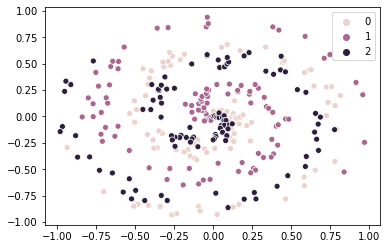

In [34]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

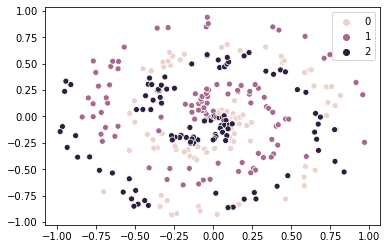

In [35]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_hat)

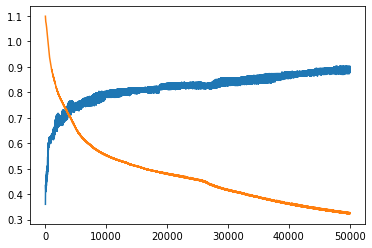

In [36]:
sns.lineplot(y=accuracy_acum , x=count)
sns.lineplot(y=loss_acum, x=count)

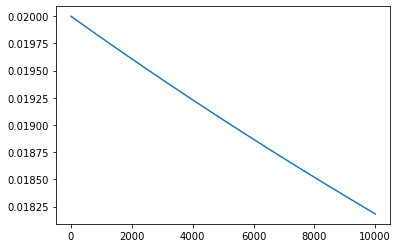

In [12]:
sns.lineplot(y=lr , x=count)